# Condition and process the HAT-P-37 data
Edited 4/16 to run through entire processing of sector to transit midtimes for a Tess sector that is contaminated by the EB

In [2]:
%matplotlib inline

import os
import shutil
import csv
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import Quantity
from astropy.time import Time
from scipy.stats import median_abs_deviation as mad
from scipy.optimize import curve_fit
from scipy.signal import find_peaks


## Define ephemeris functions and literature values for HAT-P-37 b

In [3]:
# From A-thano et. al. (https://ui.adsabs.harvard.edu/abs/2023ApJS..265....4K/abstract)
# Table 7 - constant-period model
orbital_period = 2.797440 #±0.000001 
epoch_0 = 2455642.14409 # ±0.00046
# convert t0 to TESS BJD (BTJD)
tess_zero_time = 2457000.
planet_epoch_0_BTJD = epoch_0 - tess_zero_time

def num_elapsed_transits(input_mid, ref_per, ref_mid ):
    """ How many transits is the input_mid since since the reference transit at ref_mid (using orbital ref_per). """
    n_elapsed = round((input_mid - ref_mid) / ref_per)
    return n_elapsed

def predict_linear_eph(ntr, period, ref_mid):
    """ A linear transit ephemeris. """
    return ref_mid + period * ntr
    
def predict_decaying_eph(ntr, period, ref_time, delta_p):
    """ Transit ephemeris has a linear rate of orbital decay. From Adams et al 2010a (ApJ 721 1829).\\
    delta_p = amount by which orbital period changes per orbit, assuming P = P0 + delta_P * N. \\
    Note that Pdot = delta_P x 365.25 / P0 """
    return ref_time + period * ntr + delta_p * ntr * (ntr-1)/2.
    
def get_nearest_transit(tt, ref_per, ref_mid):
    nearest_n = num_elapsed_transits(tt, ref_per, ref_mid )
    pred_tmid = predict_linear_eph(nearest_n, ref_per, ref_mid)
    return pred_tmid 

## Start by downloading all available sectors of TESS data for HAT-P-37 b

In [6]:
# Check which lightcurves are available for HAT-P-37
# I can't seem to look the system up except by its TIC number
# exptime='short' only keeps the 120-s exposures
search_result = lk.search_lightcurve("TIC 267572272", author="SPOC", exptime="short")
search_result
tess_lc_collection = search_result.download_all()  # changed name of variable to make it easier to identify
print(tess_lc_collection)

# As of 4/16/25 there should be 11 sectors
# Note Sector 26 occurs between June 9 & July 4, 2020 (in between pt 26 & pt 27 of athano paper)
# AND Sector 40 occurs between July 20 & August 3, 2021 (Epoch 1349 in both A-thano and this sector)
# AND Sector 41 contains Epoch 1354 which is also in Athano paper

LightCurveCollection of 11 objects:
    0: <TessLightCurve LABEL="TIC 267572272" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 267572272" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 267572272" SECTOR=41 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 267572272" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 267572272" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 267572272" SECTOR=55 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 267572272" SECTOR=59 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 267572272" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 267572272" SECTOR=75 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 267572272" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    10: <TessLightCurve LABEL="TIC 267572272

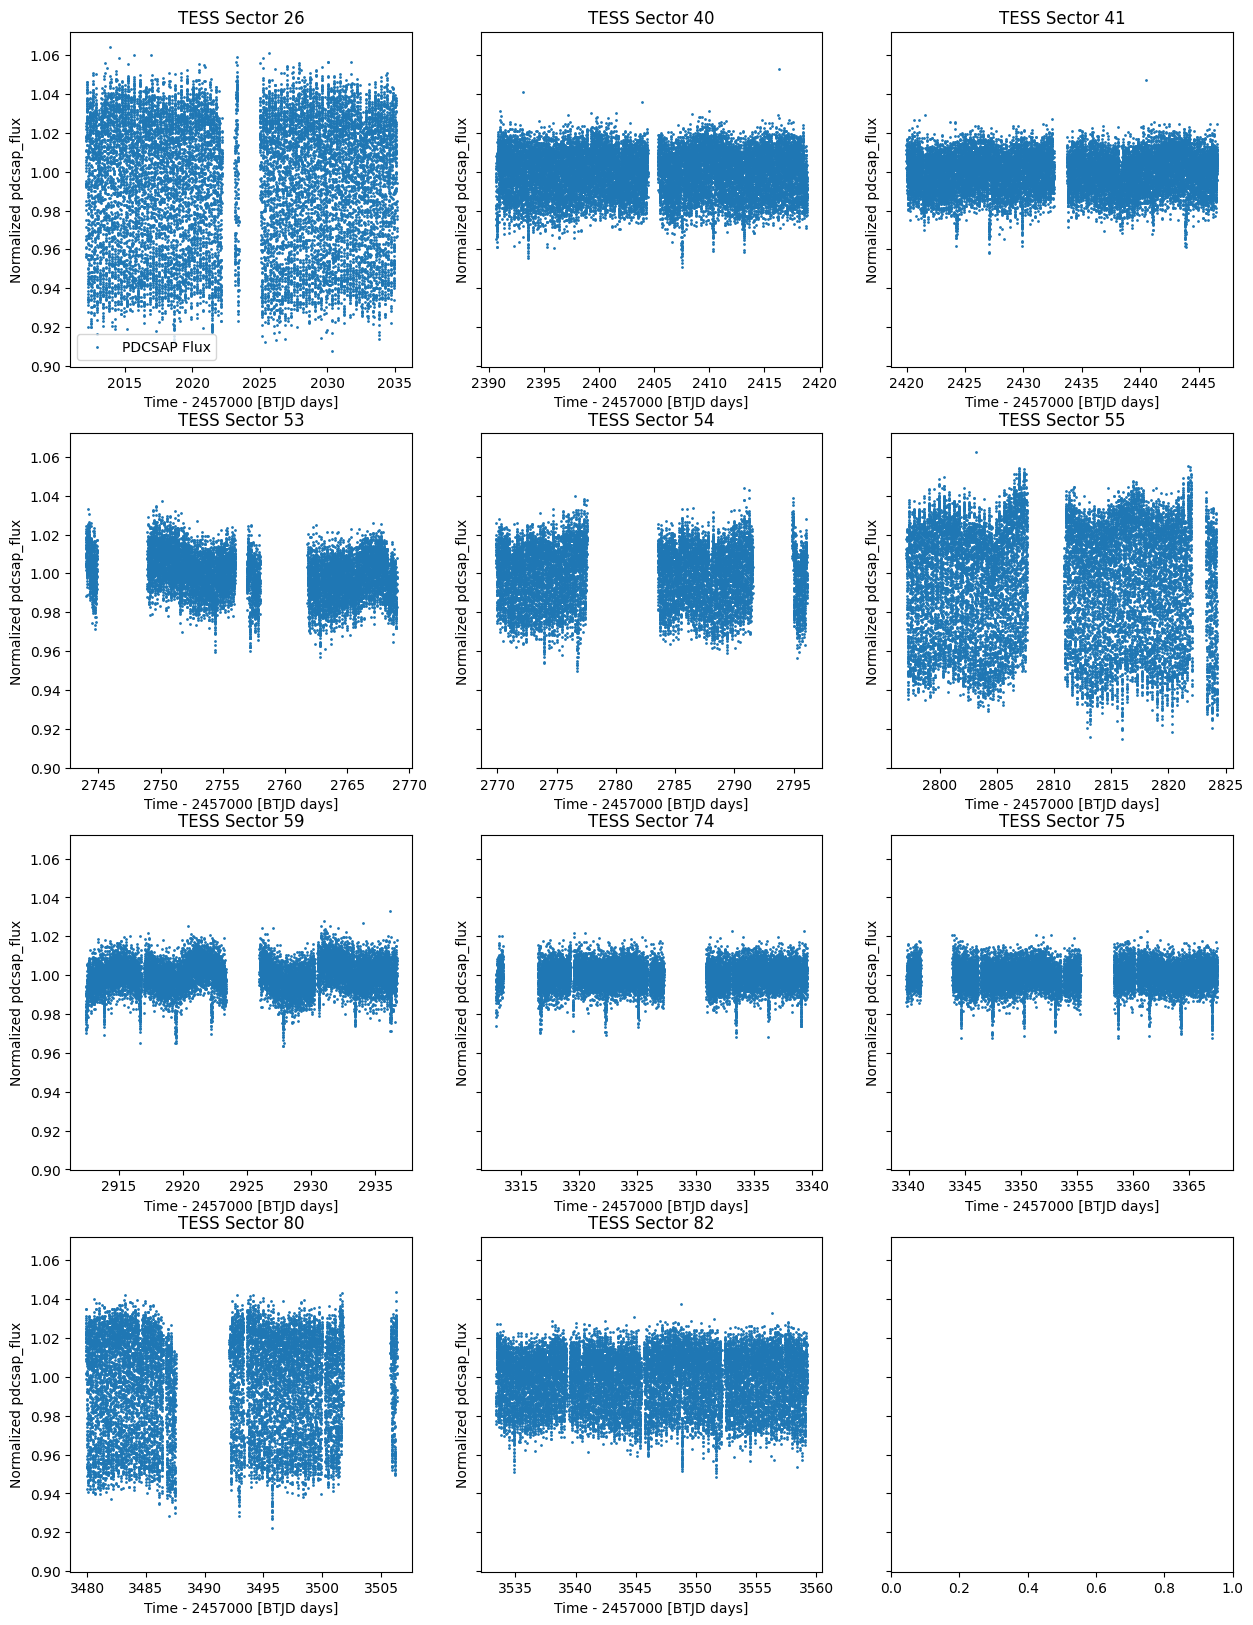

In [28]:
# PDCSAP_FLUX is the mission's estimate for lightcurve with instrument effects taken out
# Plot the PDCSAP flux after 5.0 sigma clipping for each tess sector
fig, axs = plt.subplots(4, 3, figsize=(15, 20), sharey="all") # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations

cleaned_lcs = []
for i, lc in enumerate(tess_lc_collection):
    no_nans_lc = lc.remove_nans()
    clipped_lc = no_nans_lc.remove_outliers(sigma=5.0)

    cleaned_lcs.append(clipped_lc)

    clipped_lc.scatter(column='pdcsap_flux', label='PDCSAP Flux', normalize=True, ax=axs[ax_indices[i]])
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    if i == 0:
        axs[ax_indices[i]].legend()  # keep the legend in the first plot
    else:
        axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.

# fig.savefig("figures/allSectors_sigma5_PDCSAPflux_lc.png", dpi=300, bbox_inches="tight")

## Calculate the period of the EB and identify contaminated sectors

In [29]:
# calculate the t0 for the eclipsing binary (from https://iopscience.iop.org/article/10.3847/1538-4365/ab9cae#apjsab9caes5)
HJD_shift = 2400000.5
EB_t0_HJD = 58641.4289616 + HJD_shift
# print(EB_t0_HJD)
EB_t0_BJD = 2458641.929750  # calculated using the Ohio State Applet (https://astroutils.astronomy.osu.edu/time/hjd2bjd.html)
# finally convert t0 to TESS BJD (BTJD)
EB_t0_BTJD = EB_t0_BJD - 2457000.
print(EB_t0_BTJD)

1641.9297500001267


### Use the Box Least Squares method to analyze the periodogram

59 [0.33204282 0.43394737 1.39516478 1.40014027 2.79621616 5.60277086] d
74 [2.79788074] d
75 [1.39874357 2.79515635 5.60138784] d


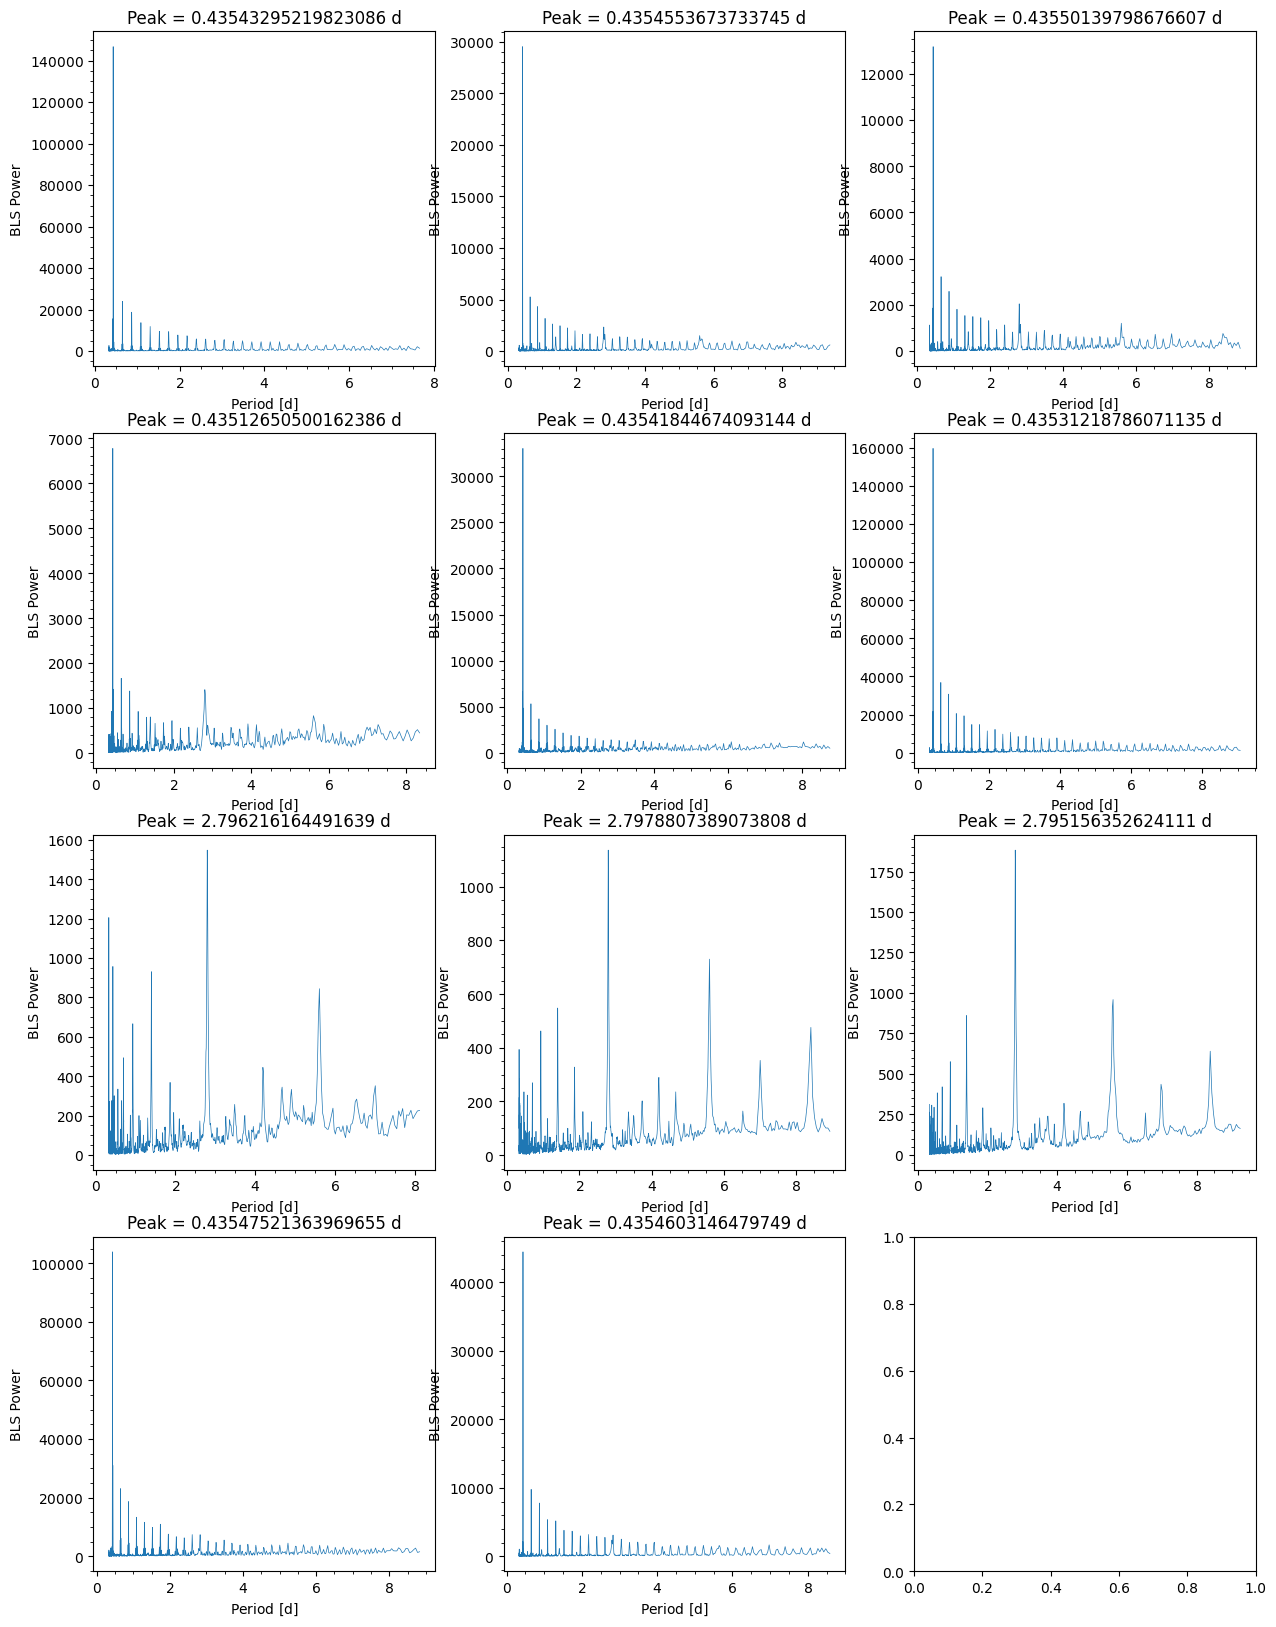

In [30]:
# Use the PDCSAP to calculate the LS for each sector of TESS data and plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2), 
              (3, 0), (3, 1), (3, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations
average_period_by_sector = []
sum_period = 0
BLS_EB_list = []
for i, lc in enumerate(cleaned_lcs):
    pg = lc.to_periodogram(method="bls")
    pg.plot(ax=axs[ax_indices[i]])
    axs[ax_indices[i]].set_title(f"Peak = {pg.period_at_max_power}")
    axs[ax_indices[i]].get_legend().remove()  # Suppress the legend because it clutters up the plot.
    
    if pg.period_at_max_power >= Quantity(1, "day"):  # identify sectors that return a period at max power of the planet vs EB
        # print("Excluded Sector: ", lc.sector, pg.period)
        peaks, props = find_peaks(pg.power, height=800)
        print(lc.sector, pg.period[peaks])

    else:
        average_period_by_sector.append(pg.period_at_max_power)
        sum_period += pg.period_at_max_power
        BLS_EB_list.append(lc)

# after calculating the peak for each sector, divde by number of sectors with the EB period to get the average period
BLS_avg_EB_period = sum_period / len(BLS_EB_list) 

# fig.savefig("figures/allSectors_BLS_periodogram.png", dpi=300, bbox_inches='tight')

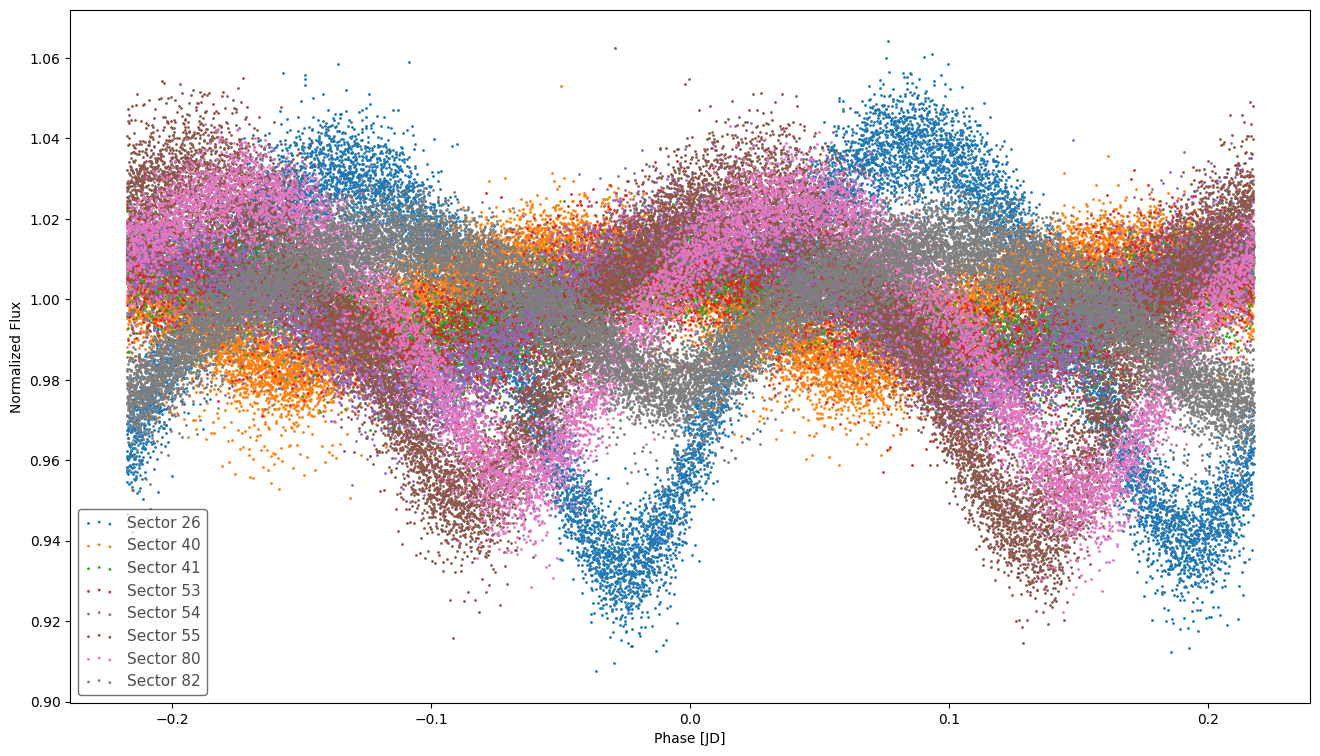

In [31]:
# for each sector that returns a period appropriate for the binary, fold according to the average EB period and plot
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for i, lc in enumerate(BLS_EB_list):
    folded_lc = lc.fold(period=average_period_by_sector[i])
    folded_lc.scatter(ax=ax, label=f"Sector {folded_lc.sector}", normalize=True);

# fig.savefig("Figures/ContaminatedSectors_EBfolded.png", dpi=300, bbox_inches="tight")

As we can tell from this plot, the level of contamination in each sector is different. Therefore, we will make an effort to individually fit each sector. 

### Starting here, we will define functions for each process so they can be applied sector by sector as needed. 

In [32]:
# create a transit mask, use the argument 'plot_data=True' for a sanity check of the mask
def mask_hatp37_transits(sector_lk, plot_data=False):
    '''returns lightkurve object of a full sector without the transits, sector_lk MUST be a lightkurve LightCurve obj'''
    known_transit_mask = sector_lk.create_transit_mask(transit_time=planet_epoch_0_BTJD, 
                                                   period=orbital_period,
                                                   duration=0.1)
    # NOTE: create transit mask returns an array with True for every data point IN TRANSIT, so we need to flip it to remove the transits
    no_transit_mask = known_transit_mask == False  # this inverts the mask to mask out ONLY the transits
    NO_transits_lk = sector_lk[no_transit_mask]

    if plot_data:
        fig = plt.figure()
        ax=fig.add_subplot(111)
        sector_lk.scatter(ax=ax, normalize=True, color='k', label="All Data")
        NO_transits_lk.scatter(ax=ax, normalize=True, label="Transits Masked")
        ax.get_legend() 
        fig.savefig(f"figures/FullSector_{sector_lk.sector}_NO_transits.png", dpi=300, bbox_inches="tight")

    return NO_transits_lk           


In [ ]:
# Ran to create all the masked transit plots.
for lk_obj in BLS_EB_list:
    no_transits = mask_hatp37_transits(lk_obj, plot_data=True)

In [34]:
# create a binned and folded lightcurve
# NOTE: Since the orbital period is an argument these functions can be used for either the EB or the planet orbital period. 

def bin_lightcurve(lightcurve, binsize=120./86400.):  # 120 seconds to days
    time = lightcurve.time.value
    flux = lightcurve.flux.value 
    
    binned_time = np.array([])
    binned_flux = np.array([])
    binned_err = np.array([])

    cur_point = np.min(time) + 0.5*binsize
    while(cur_point <= np.max(time) - 0.5*binsize):
        ind = np.abs(cur_point - time) < 0.5*binsize

        if(len(time[ind]) > 0):
            binned_time = np.append(binned_time, np.mean(time[ind]))
            binned_flux = np.append(binned_flux, np.mean(flux[ind]))
            binned_err = np.append(binned_err, np.std(flux[ind]))
        
        cur_point += binsize
    
    astropy_time = Time(binned_time, format=lightcurve.time.format)
    binned_lightcurve = lk.LightCurve(time=astropy_time, flux=binned_flux, flux_err=binned_err)
    return binned_lightcurve


def fold_lightcurve(lightcurve, period, ref_mid, output_rel_times=False):
    # return a lightkurve object with the time folded
    # print(f"Folding to period {period} with ref mid {ref_mid}")
    times = lightcurve.time.value
    rel_times = times - ref_mid - period/2. # to plot transit in center
    mod_rel_times = rel_times % period
    
    if output_rel_times:
        folded_lightcurve = lk.LightCurve(time=mod_rel_times, flux=lightcurve.flux, flux_err=lightcurve.flux_err)
    else:
        mid_elapsed = num_elapsed_transits(min(times), period, ref_mid) 
        midsector_time = predict_linear_eph(mid_elapsed, period, ref_mid)
        folded_times_assigned_mid_sector = mod_rel_times+midsector_time-period/2.
        folded_astropy_time = Time(folded_times_assigned_mid_sector, format="btjd")
        folded_lightcurve = lk.LightCurve(time=folded_astropy_time, flux=lightcurve.flux, flux_err=lightcurve.flux_err)
    return folded_lightcurve

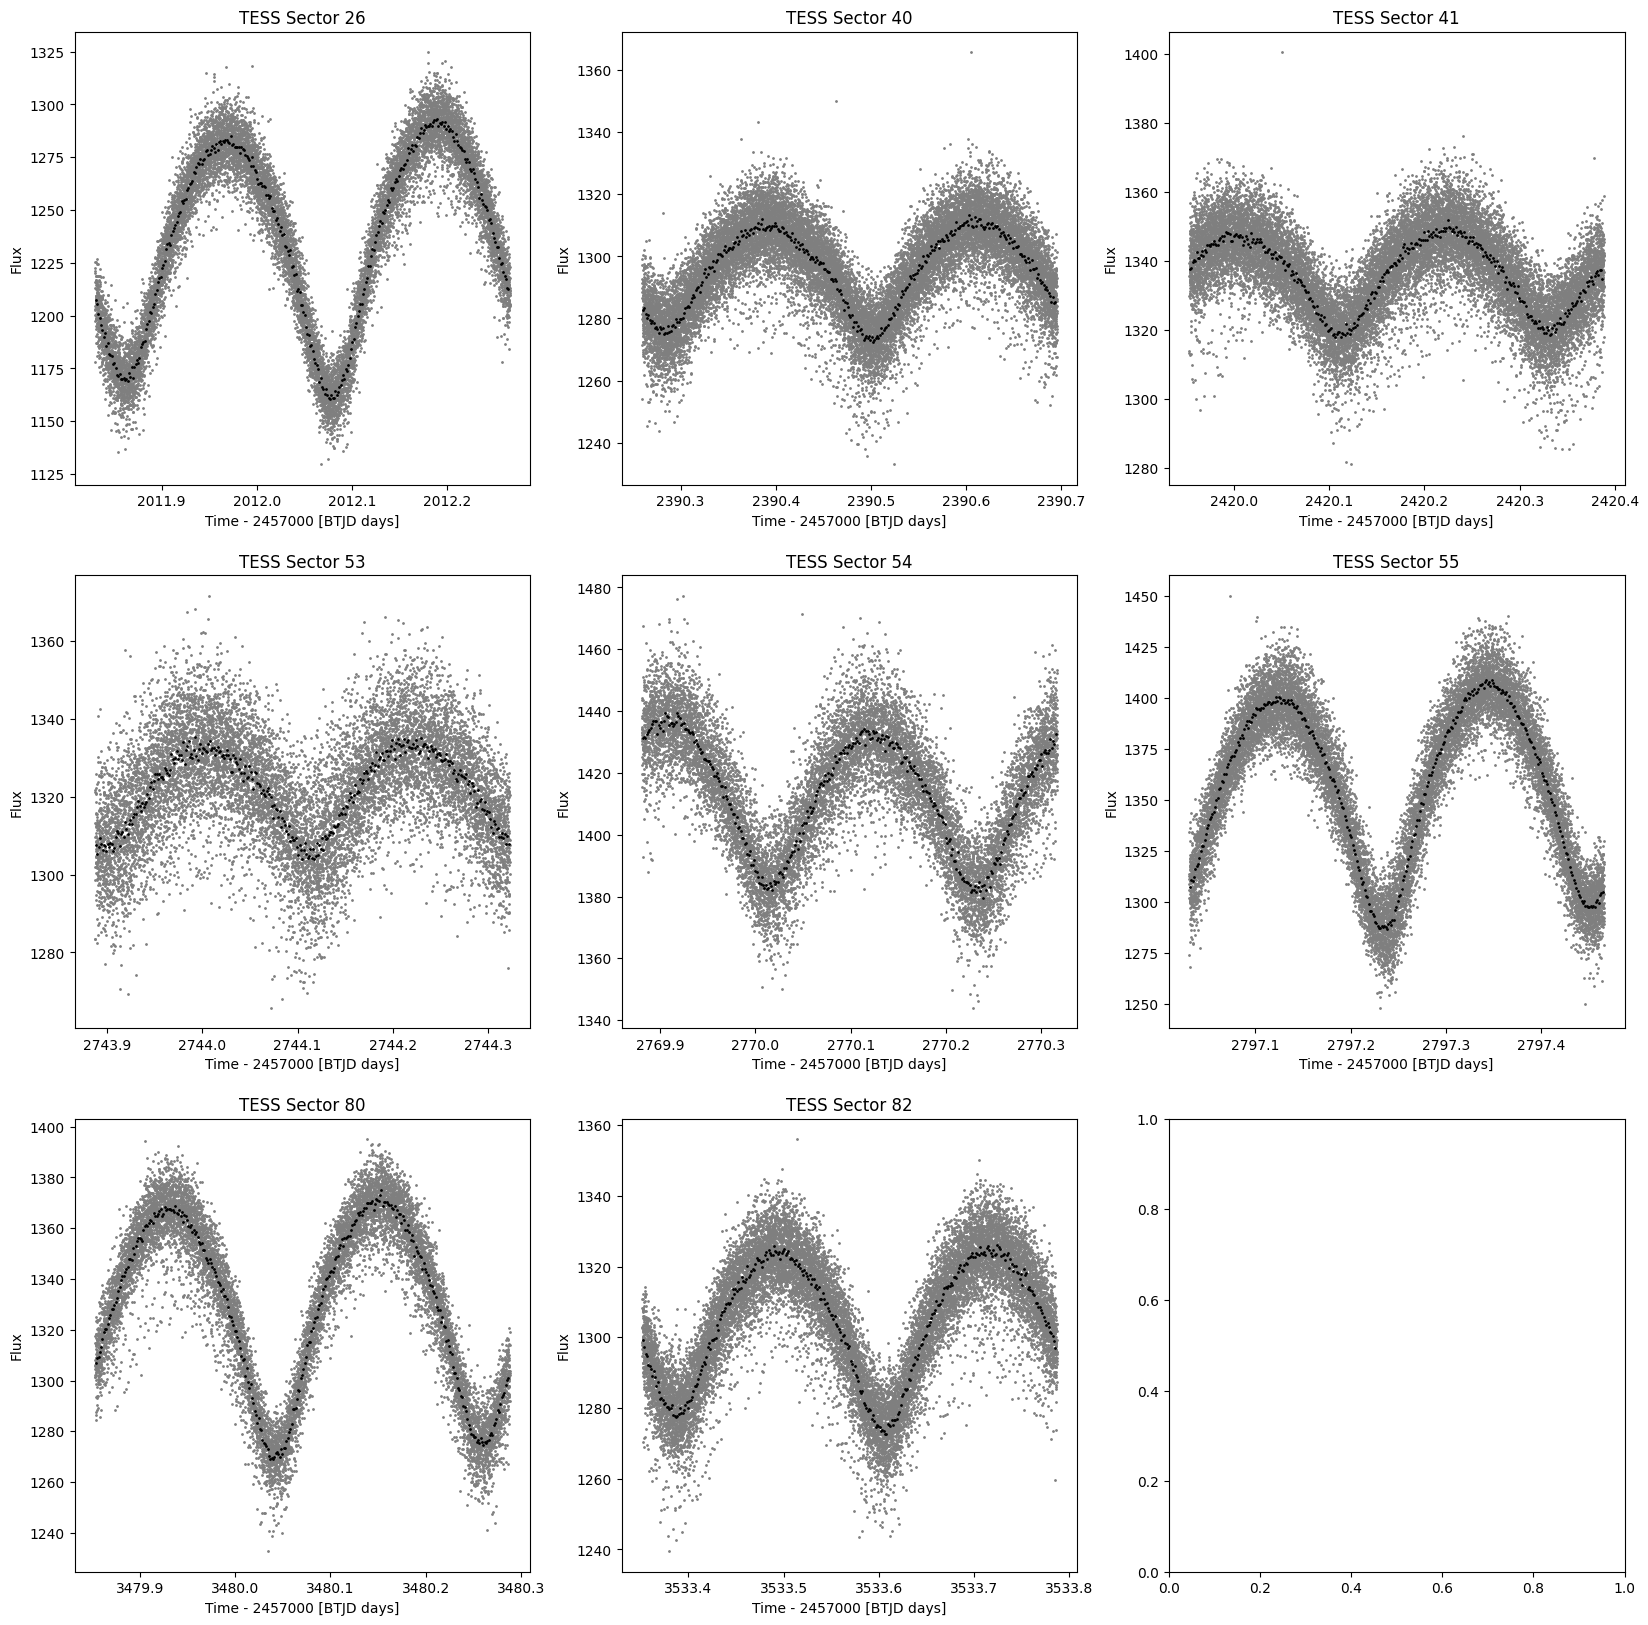

In [35]:
# Try phase folding each sector individually. 
fig, axs = plt.subplots(3, 3, figsize=(20, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations

for i, lc in enumerate(BLS_EB_list):
    folded_lc = fold_lightcurve(lc, period=average_period_by_sector[i].value, ref_mid=EB_t0_BTJD)
    binned_folded_lc = bin_lightcurve(folded_lc)
    folded_lc.scatter(ax=axs[ax_indices[i]], color="tab:gray", zorder=-1)
    binned_folded_lc.scatter(ax=axs[ax_indices[i]], color='k')
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    axs[ax_indices[i]].ticklabel_format(useOffset=False)

# fig.savefig("Contamined_bySector_foldbin_assignedtimes.png", dpi=300, bbox_inches="tight")

In [42]:
def detrend_w_SavGol(sector_lc, binary_period, binary_epoch_0_BTJD):  # , orbital_period):
    # create the mask, fold on the binary, and bin the points to create the data to interpolate
    masked_lc = mask_hatp37_transits(sector_lc) # Mask out transit
    folded_lc = fold_lightcurve(masked_lc, period=binary_period, ref_mid=binary_epoch_0_BTJD)
    binned_lc = bin_lightcurve(folded_lc) # default bins to 120s 

    # the time series that needs interpolating should included ALL time folded (ie no transit mask)
    fold_sector = fold_lightcurve(sector_lc, period=binary_period, ref_mid=binary_epoch_0_BTJD)
    interp_time = fold_sector.time.value

    # Now interpolate across whole time-series unfolded
    interp_trend = np.interp(interp_time, binned_lc.time.value, binned_lc.flux.value)

    # detrend by dividing the WHOLE sector flux by the interpolated
    detrended_flux = sector_lc.flux.value / interp_trend
    detrended_err = np.ones(detrended_flux.shape)*mad(detrended_flux)
    
    detrended_lc = lk.LightCurve(time=sector_lc.time, flux=detrended_flux, flux_err=detrended_err, meta=sector_lc.meta)
    return detrended_lc, interp_trend

In [37]:
# test detrend & flatten with ONE sector
test = BLS_EB_list[1]

# fold = fold_lightcurve(test, period=orbital_period, ref_mid=planet_epoch_0_BTJD)
# fold.scatter(ax=axs[ax_indices[i]], normalize=True, color="tab:blue")
detrend_lc, trend = detrend_w_SavGol(test, binary_period=average_period_by_sector[i].value, binary_epoch_0_BTJD=EB_t0_BTJD)
detrend_lc.meta = test.meta
# detrend_lc.scatter(ax=ax1)
# ax1.plot(lc.time.value, trend, color='k')
# fold and plot detrended lightcurves on the transit orbital period
detrend_fold_lc = fold_lightcurve(detrend_lc, period=orbital_period, ref_mid=planet_epoch_0_BTJD)
detrend_fold_lc.scatter(ax=axs[ax_indices[i]], normalize=True, color="tab:gray")
axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
axs[ax_indices[i]].ticklabel_format(useOffset=False)

detrend_flatten, trend = detrend_lc.flatten(window_length=251, return_trend=True)
detrend_flatten.scatter(ax=ax, color="k")
trend.scatter(ax=ax)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

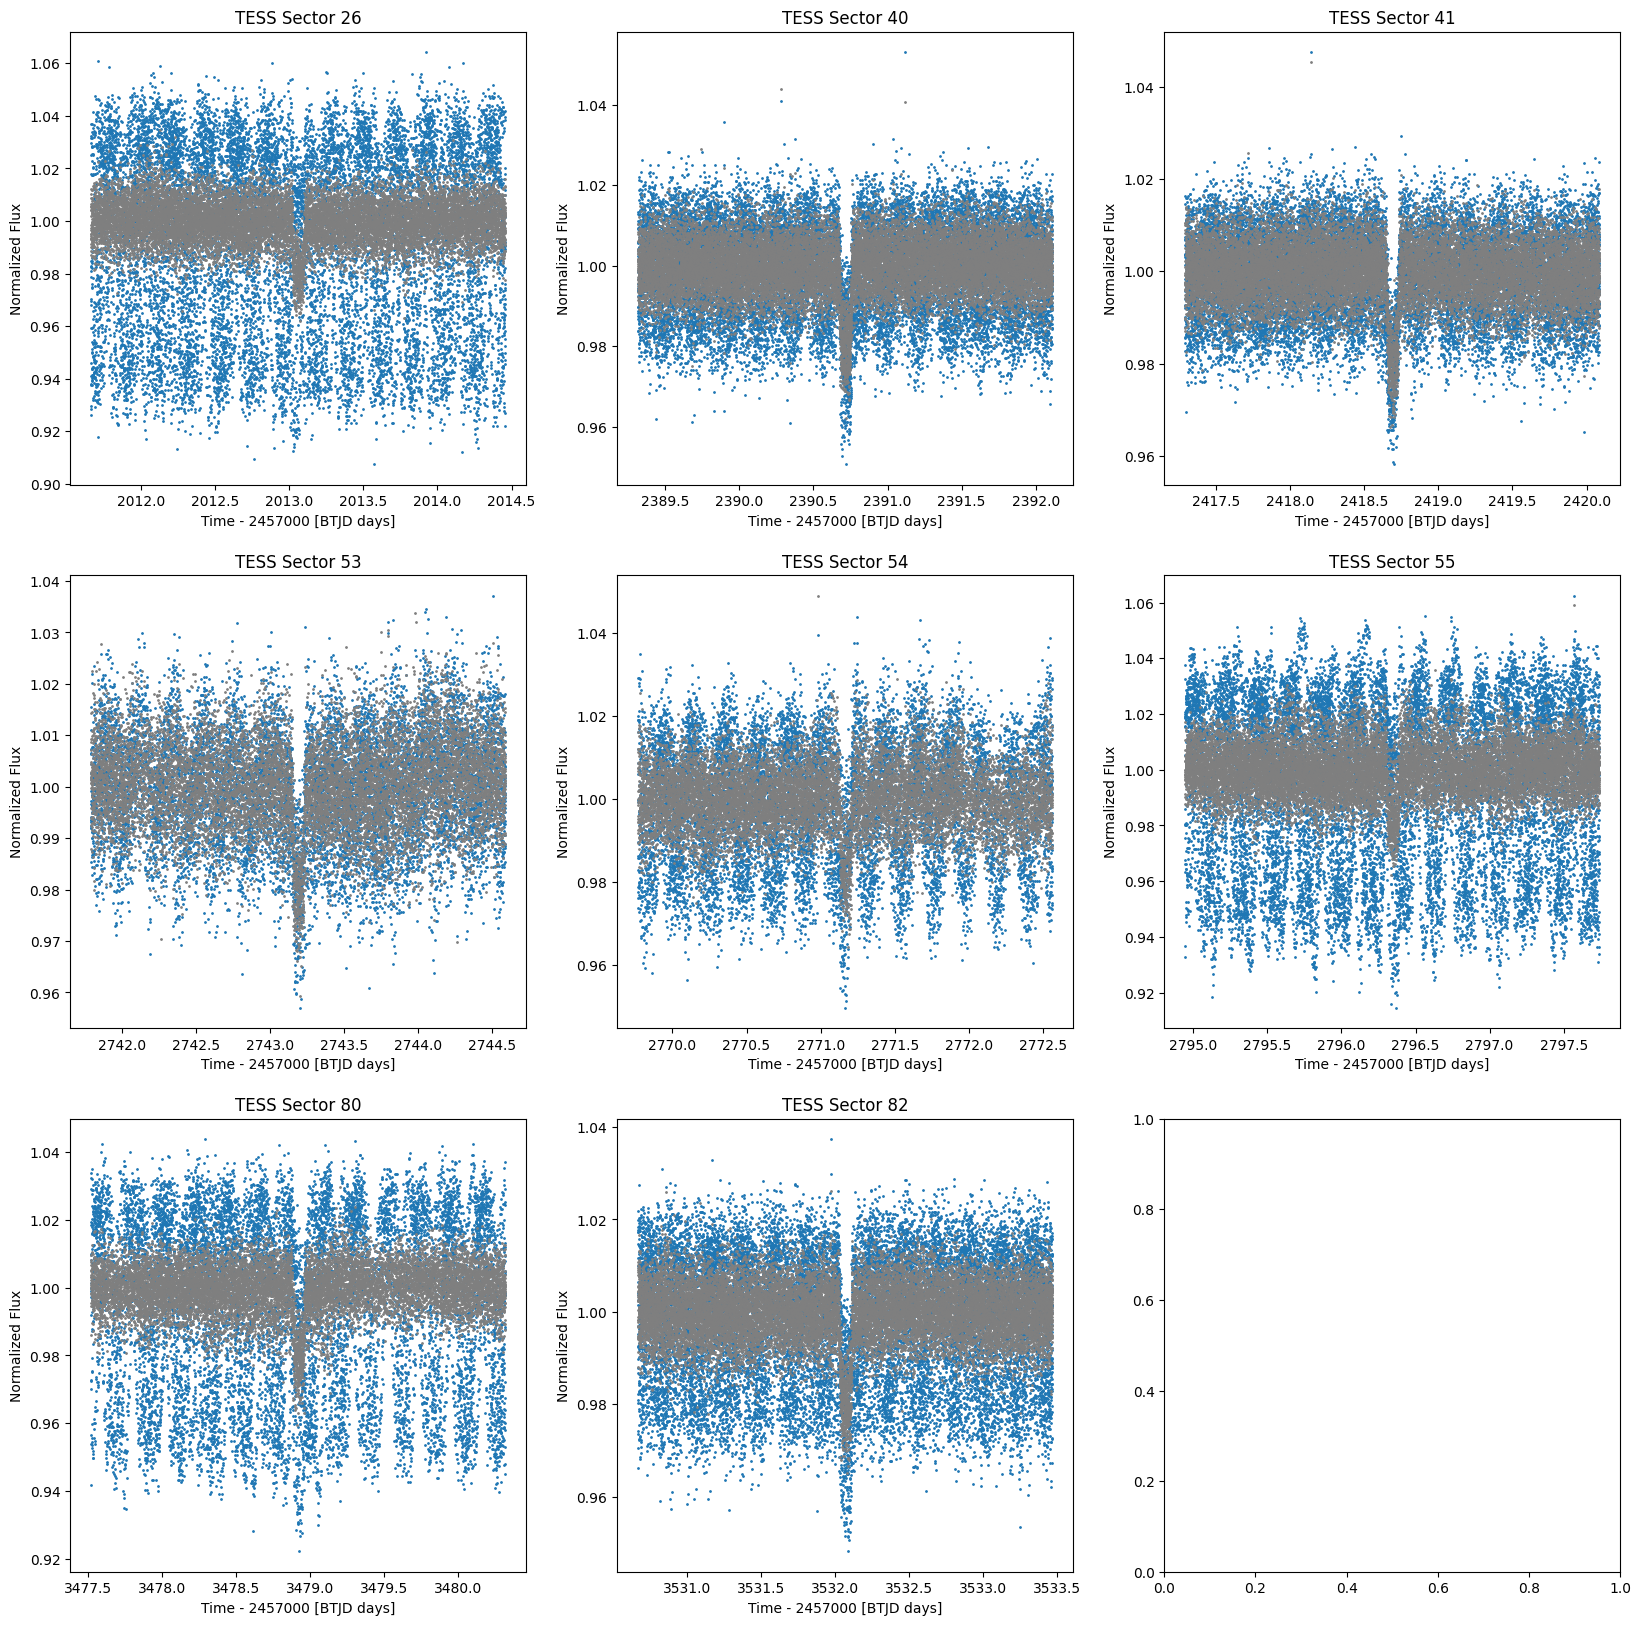

In [ ]:
# Detrend each sector 
fig, axs = plt.subplots(3, 3, figsize=(20, 20)) # create a figure with 4 rows and 3 columns to slot the tess lightcurves into
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations

detrended_list = []
for i, lc in enumerate(BLS_EB_list):
    fold = fold_lightcurve(lc, period=orbital_period, ref_mid=planet_epoch_0_BTJD)
    fold.scatter(ax=axs[ax_indices[i]], normalize=True, color="tab:blue")
    detrend_lc, trend = detrend_w_SavGol(lc, binary_period=average_period_by_sector[i].value, binary_epoch_0_BTJD=EB_t0_BTJD)
    detrended_list.append(detrend_lc)
    # detrend_lc.scatter(ax=ax1)
    # ax1.plot(lc.time.value, trend, color='k')
    # fold and plot detrended lightcurves on the transit orbital period
    detrend_fold_lc = fold_lightcurve(detrend_lc, period=orbital_period, ref_mid=planet_epoch_0_BTJD)
    detrend_fold_lc.scatter(ax=axs[ax_indices[i]], normalize=True, color="tab:gray")
    axs[ax_indices[i]].set_title(f"TESS Sector {lc.sector}")
    axs[ax_indices[i]].ticklabel_format(useOffset=False)

# fig.savefig("Detrended_bySector_transitfold.png", dpi=300, bbox_inches="tight")

## Now take the detrended data and chunk out into individual light curves
### NOTE: **START HERE** if the sector is not contaminated

In [54]:
# test_sector = cleaned_lcs[7].normalize()  # working sector 75 - for sectors that are not detrended, they MUST be normalized before fitting

test_sector = detrended_list[1]  
print(test_sector.sector)

# make a sector folder to hold plots
use_dir = "../figures/"
sector_dir = use_dir+ f"S{test_sector.sector}/"
if os.path.isdir(sector_dir) == False:
    print("making",sector_dir)
    os.makedirs(sector_dir)

## Note, we want the UNFOLDED time here
detrended_time = test_sector.time.value
min_t = min(detrended_time)
max_t = max(detrended_time)
print("Min",min_t,"max",max_t)


40
Min 2390.655093166175 max 2418.8552880725647


In [55]:
min_elapsed = num_elapsed_transits(min_t, orbital_period, planet_epoch_0_BTJD ) 
max_elapsed = num_elapsed_transits(max_t, orbital_period, planet_epoch_0_BTJD )
print("Transits elapsed since ref midtime to start of data series:", min_elapsed)
print("Transits elapsed since ref midtime to end of data series:  ", max_elapsed)

# min_elapsed = num_elapsed_transits(min_t, orbital_period, planet_epoch_0_BTJD )
# max_elapsed = num_elapsed_transits(max_t, orbital_period, planet_epoch_0_BTJD )
# print("Transits elapsed since ref midtime to start of data series:", min_elapsed)
# print("Transits elapsed since ref midtime to end of data series:  ", max_elapsed)

Transits elapsed since ref midtime to start of data series: 1340
Transits elapsed since ref midtime to end of data series:   1350


In [56]:
n_range = np.arange(min_elapsed, max_elapsed)
print("Epochs elapsed in Sector ", test_sector.sector)
print(n_range)
epochs_elapsed_athano = n_range

Epochs elapsed in Sector  40
[1340 1341 1342 1343 1344 1345 1346 1347 1348 1349]


In [57]:
pred_midtimes = predict_linear_eph(n_range, orbital_period, planet_epoch_0_BTJD)
pred_chunk_start = pred_midtimes -  orbital_period/2.
pred_chunk_end = pred_midtimes +  orbital_period/2.

In [58]:
chunk_times= []
chunk_mids = []
for nn in range(len(pred_midtimes)):
    chunk_times.append( [pred_chunk_start[nn],pred_chunk_end[nn]] )
    utc_f = Time(pred_midtimes[nn]+tess_zero_time,format="jd").isot
    chunk_utc = utc_f.split("T")[0].replace("-","")  + "-"+utc_f.split("T")[1].split(":")[0]
    chunk_mids.append(chunk_utc)

## Plot chunked light curve

In [59]:
chunk_masks=[]
chunked_lc_list = []
has_data_names = []

for ii in range(len(chunk_times)):
    chunk_masks.append( (detrended_time >= chunk_times[ii][0]) & (detrended_time < chunk_times[ii][1]) )
    if(list(chunk_masks[ii]).count(True)>0):
        chunk_lc = test_sector[chunk_masks[ii]]
        chunked_lc_list.append(chunk_lc)
        # chunk_lc_err = test_sector.flux_err.value[chunk_masks[ii]]
        # chunk_time = detrended_time[chunk_masks[ii]]
        # has_data_time.append(chunk_time)
        # has_data_lc.append(chunk_lc)
        # has_data_err.append(chunk_lc_err)
        has_data_names.append(f"HATP37b_{chunk_mids[ii]}")

print(len(chunked_lc_list))

10


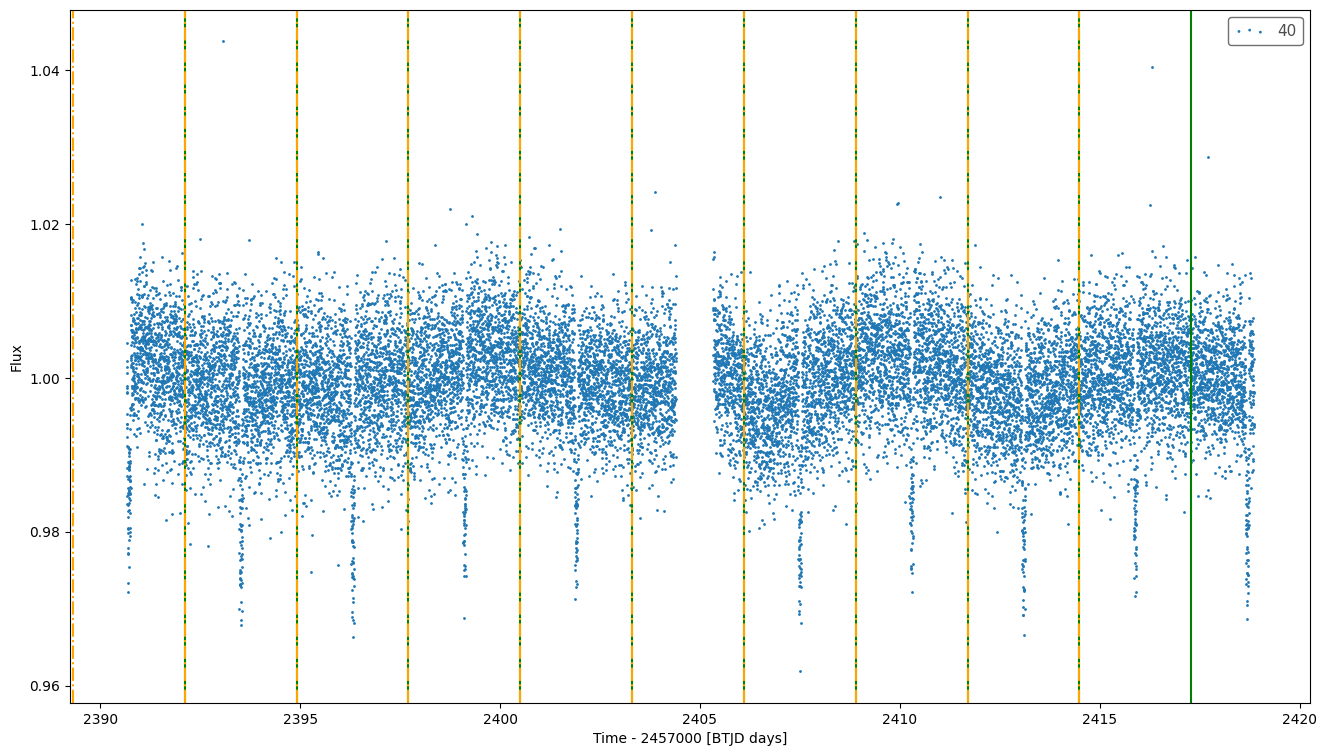

In [62]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
test_sector.scatter(ax=ax, label=test_sector.sector)
for val in chunk_times:
    ax.axvline(val[0], color='orange', linestyle='-.')
    ax.axvline(val[1], color='g')

fig_name = sector_dir + "sector_w_chunks_drawn.png"
# fig.savefig(fig_name, dpi=300, bbox_inches="tight")

### output to light curves to be fitted

HATP37b_20200612-13
1665


HATP37b_20200615-08
1976
HATP37b_20200618-03
1995
HATP37b_20200620-22
1492
HATP37b_20200623-17
693
HATP37b_20200626-13
1970
HATP37b_20200629-08
1992
HATP37b_20200702-03
1967


<Figure size 600x400 with 0 Axes>

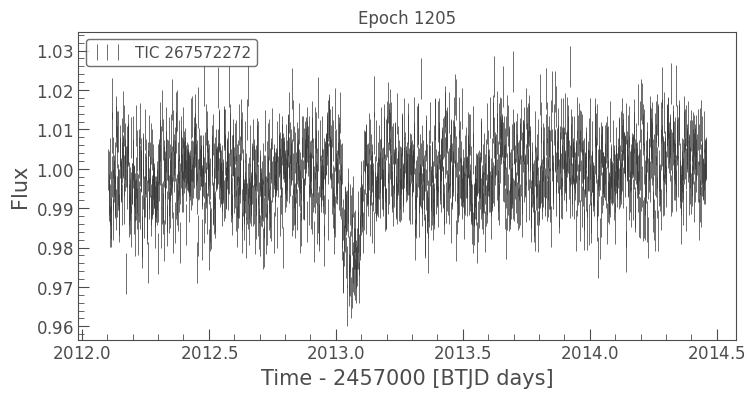

<Figure size 600x400 with 0 Axes>

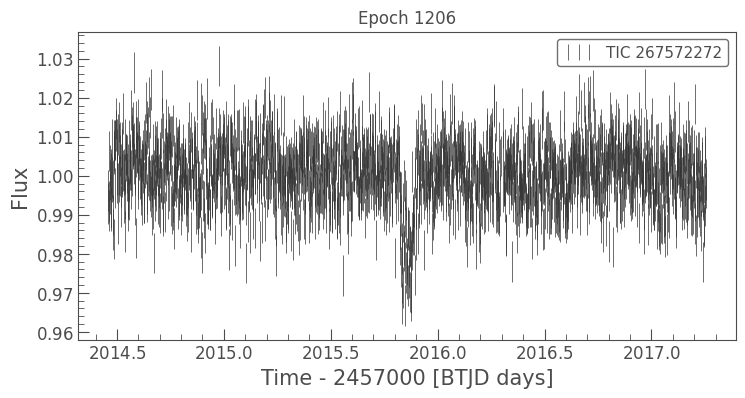

<Figure size 600x400 with 0 Axes>

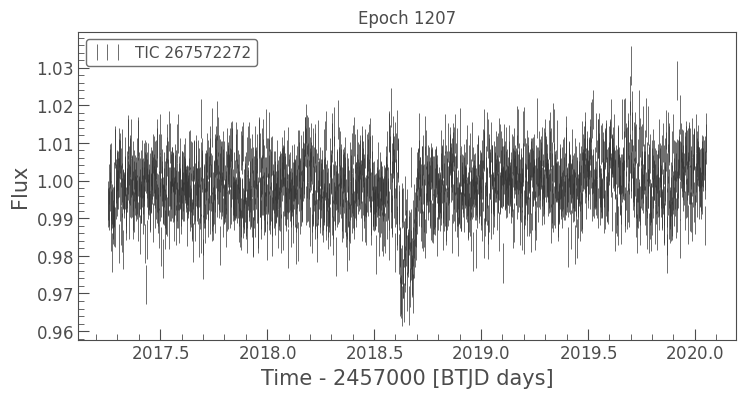

<Figure size 600x400 with 0 Axes>

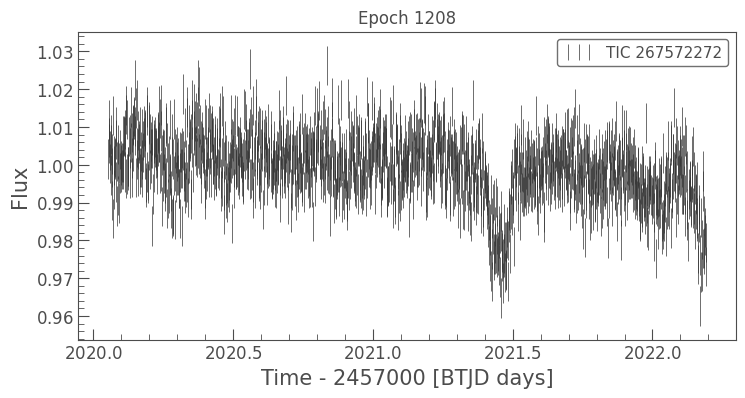

<Figure size 600x400 with 0 Axes>

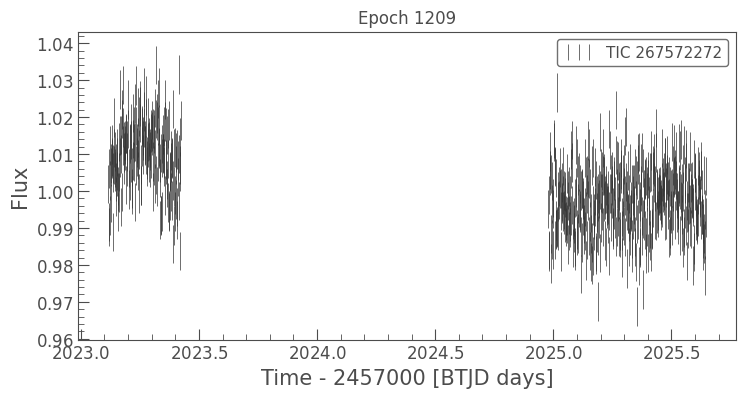

<Figure size 600x400 with 0 Axes>

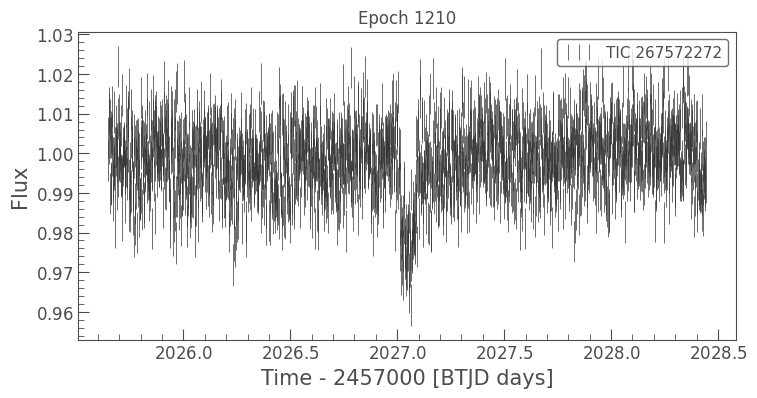

<Figure size 600x400 with 0 Axes>

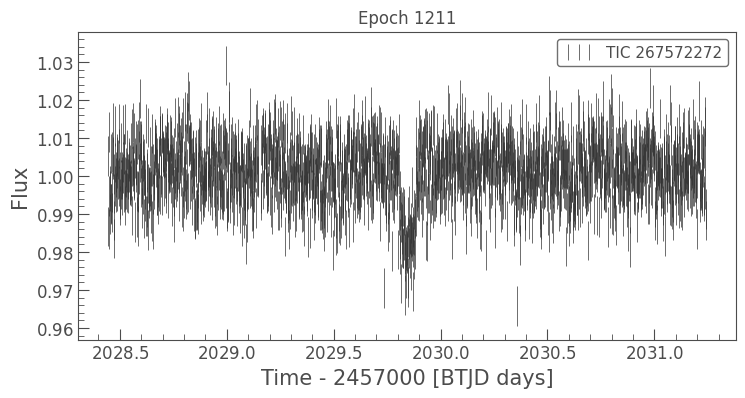

<Figure size 600x400 with 0 Axes>

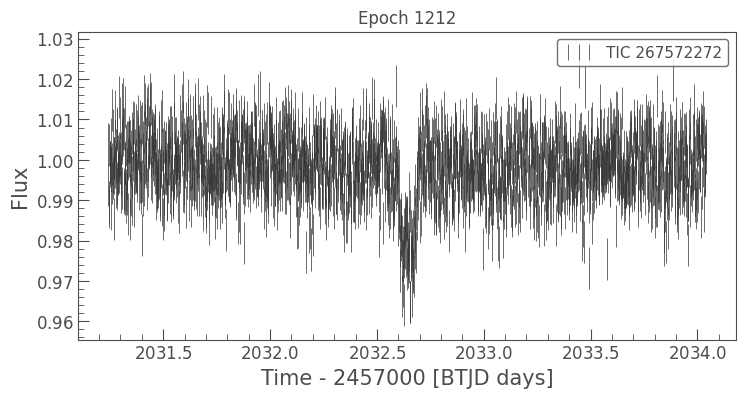

In [53]:
for nn,transit in enumerate(has_data_names):
    print(transit)
    print(len(chunked_lc_list[nn].time.value))
    ## individual
    plot_file = sector_dir + "transit_"+transit+".png"
    fig=plt.figure(figsize=(6,4),facecolor='white')
    chunked_lc_list[nn].errorbar()
    plt.title(f"Epoch {epochs_elapsed_athano[nn]}")
    # plt.savefig(plot_file, dpi=150, bbox_inches='tight')           

## Fit _good_ chunked light curves to Carter Model

In [ ]:
# Carter Model: https://iopscience.iop.org/article/10.1086/592321/pdf
def Carter_model(time, tc, f0, delta, T, tau):
    # tc - central transit time
    # f0 - out-of-transit baseline
    # delta - difference in flux from the background to the deepest part of the transit f0*r**2
    # T - transit duration (full planet in front of the star) 2*tau0*sqrt(1-b**2) 
    # tau =  duration of ingress / egress 2*tau0*r**2/sqrt(1 - b**2)

    flux = np.zeros_like(time)

    ind = np.abs(time - tc) <= (T/2. - tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta

    ind = ((T/2. - tau/2.) < np.abs(time - tc)) & ((T/2. + tau/2.) > np.abs(time - tc))
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta + (delta/tau)*(np.abs(time[ind] - tc) - T/2. + tau/2.)

    ind = np.abs(time - tc) >= (T/2. + tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0

    return flux

In [ ]:
# sector 26 2, 3, 5
# For sector 40, throw out 4
# sector 41, throw out 4
# secctor 53, throw out 0, 1
# For sector 54, throw out 3, 7
# sector 55, toss 4
# For sector 74, throw out 0, 2, 5, 6
# For ector 75, throw out 0, 1, 6
# no filter for sectors: 80, 82


filter= [ 2,3,5 ]

filtered_chunk_lc_list = []
filtered_transit_names = []
filtered_epochs = []
for i, lc in enumerate(chunked_lc_list):
    if i in filter:
        pass
    else:
        filtered_chunk_lc_list.append(lc)
        filtered_transit_names.append(has_data_names[i])
        filtered_epochs.append(epochs_elapsed_athano[i])

print(len(filtered_chunk_lc_list))

4


In [ ]:
def calc_Carter_initial_guesses(lightcurve):
    # tc - central transit time
    # f0 - out-of-transit baseline
    # delta - difference in flux from the background to the deepest part of the transit f0*r**2
    # T - transit duration (full planet in front of the star) 2*tau0*sqrt(1-b**2) 
    # tau =  duration of ingress / egress 

    tc = lightcurve.time.value[np.argmin(lightcurve.flux.value)] # estimate the central transit time to be the time w/ the minimum flux value
    background = np.median(lightcurve.flux.value)  # The background value is very nearly the median for all the data (f0)
    
    # for delta, we approx. as f0 - min flux
    min_flux = np.min(lightcurve.flux.value)
    delta = background - min_flux
    
    # T = T2 to T3 all values from Bakos et. al 2012
    T14 = 0.0971  # days +/- 0.0015
    T12 = 0.0153  # days +/- 0.0013
    duration = T14 - (2*T12)

    # (T r) / (1-b^2)
    ratio_of_planet_to_star_radius = 0.1378  # Bakos et al. 2012 +/- 0.0030
    b = 0.505 # +0.041/-0.062
    tau = (duration * ratio_of_planet_to_star_radius) / (1-b**2)

    # Let's set our initial guesses - tc, f0, delta, T, tau
    initial_guesses = np.array([tc, background, delta, duration, tau])
    return initial_guesses

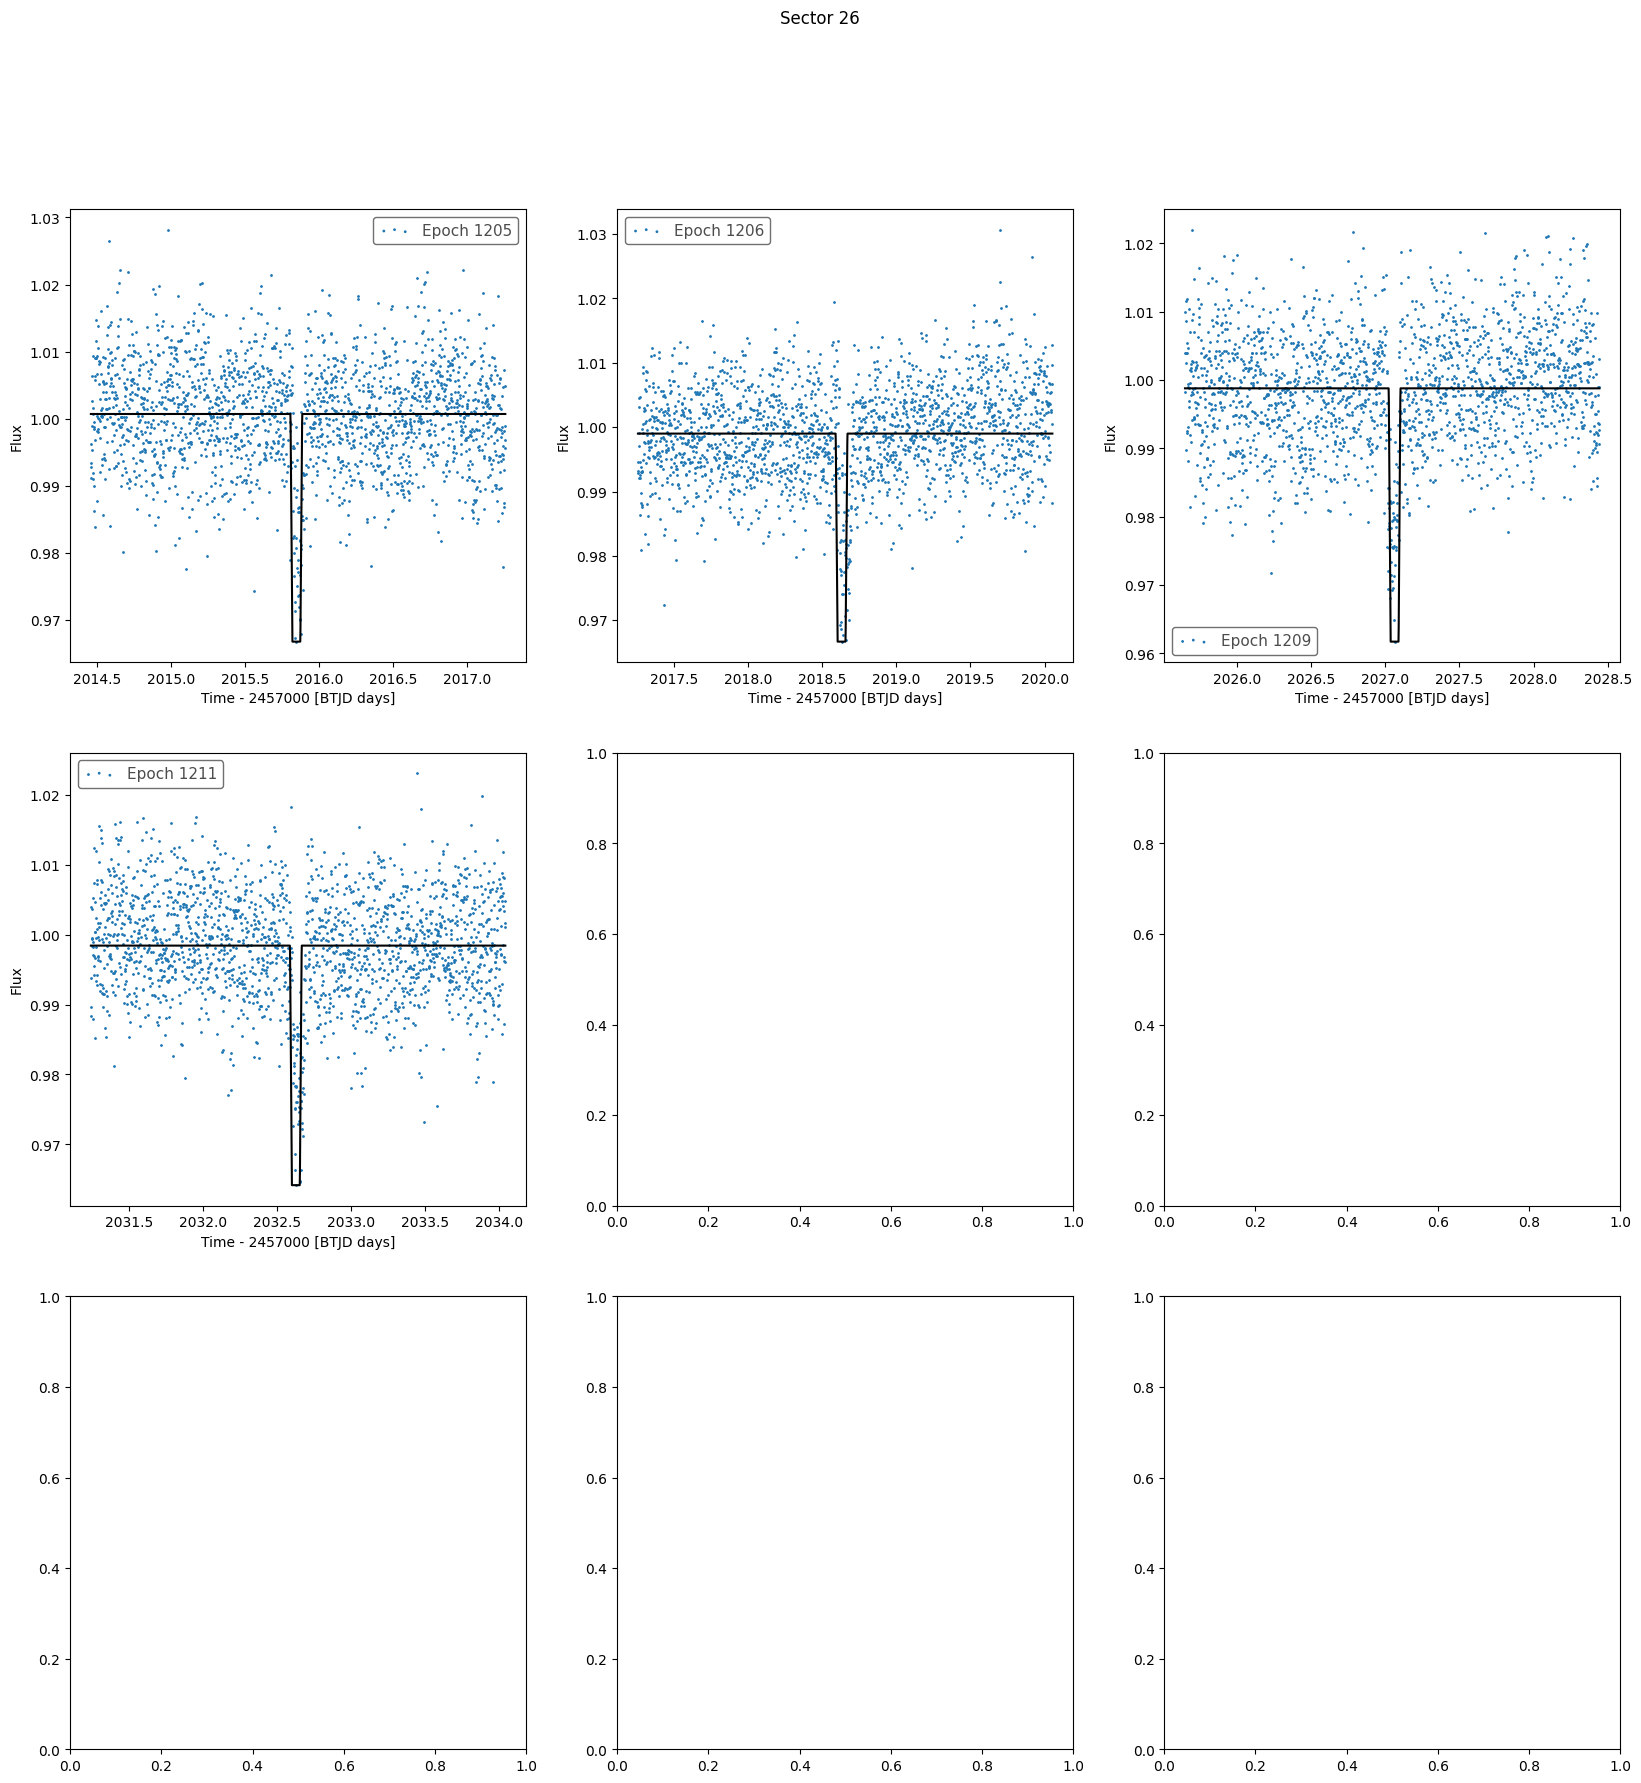

In [ ]:
# create a figure with 3 rows and 3 columns to slot the chunked lightcurves into
fig, axs = plt.subplots(3, 3, figsize=(20, 20)) 
ax_indices = [(0, 0), (0, 1), (0, 2), 
              (1, 0), (1, 1), (1, 2), 
              (2, 0), (2, 1), (2, 2)]
# note: this is a 1D list, but coded in this shape to help identify plot locations

for nn, lc in enumerate(filtered_chunk_lc_list):
    initial_params = calc_Carter_initial_guesses(lc)
    lc.scatter(ax=axs[ax_indices[nn]], label=f"Epoch {filtered_epochs[nn]}")
    axs[ax_indices[nn]].plot(lc.time.value, Carter_model(lc.time.value, *initial_params), color="k")

fig.suptitle(f"Sector {filtered_chunk_lc_list[0].sector}", fontsize="large")
fig.savefig(f"../figures/Sec{filtered_chunk_lc_list[0].sector}_Carter_initial_guess.png", dpi=300, bbox_inches="tight")

Epoch 1205 best fit Tm: 2015.86, sigma Tm: 0.00136374
Epoch 1206 best fit Tm: 2018.66, sigma Tm: 0.000787589
Epoch 1209 best fit Tm: 2027.05, sigma Tm: 0.00107764
Epoch 1211 best fit Tm: 2032.64, sigma Tm: 0.00141705
CSV file tess_hatp37_S26_fits.csv has been created successfully!


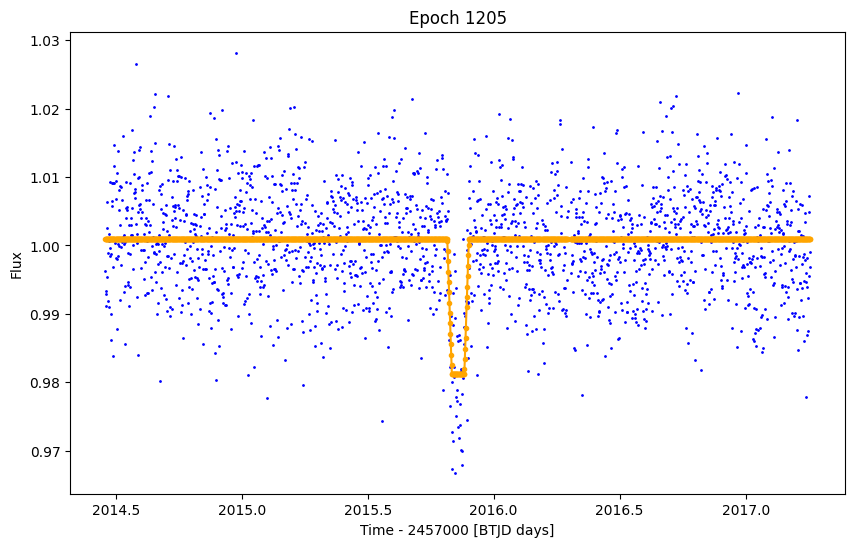

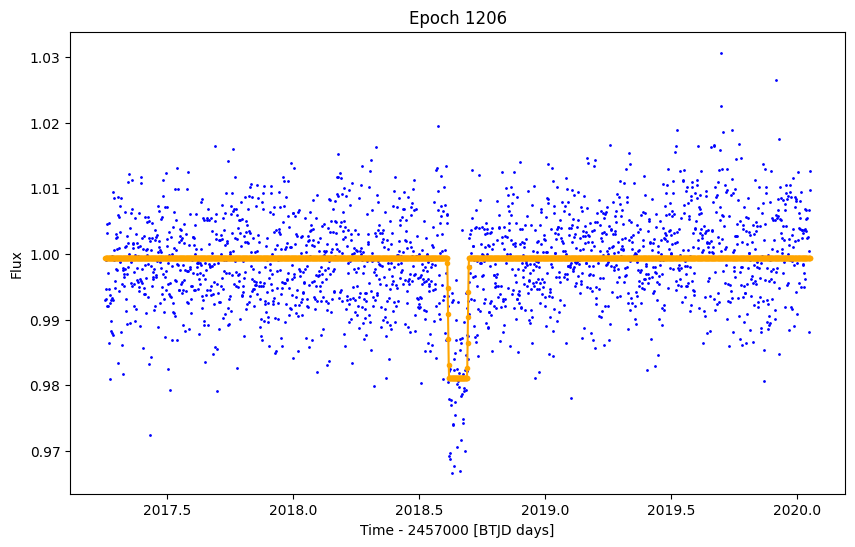

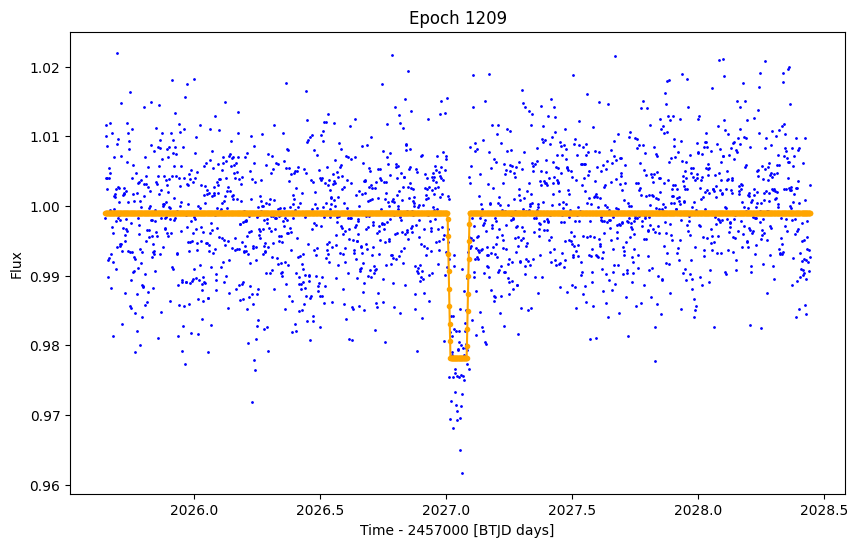

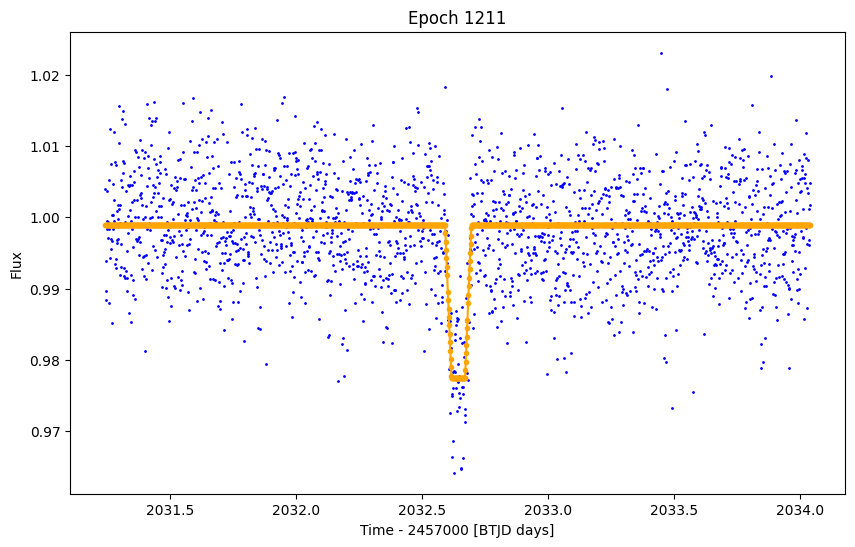

In [ ]:
#initalize csv to save values in
csv_name = f'tess_hatp37_S{test_sector.sector}_fits.csv'
with open(csv_name, 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Epoch', 'Tm', 'sigma_Tm'])

      for nn, lc in enumerate(filtered_chunk_lc_list):
            initial_params = calc_Carter_initial_guesses(lc)
            transit_shape_params, pcov = curve_fit(Carter_model, lc.time.value, lc.flux.value,
                              p0=initial_params, sigma=lc.flux_err)
            transit_shape_params_unc = np.sqrt(np.diag(pcov))
            print("Epoch %g best fit Tm: %g, sigma Tm: %g" %\
                  (filtered_epochs[nn], 
                   transit_shape_params[0], 
                   transit_shape_params_unc[0]))
            

            writer.writerow([filtered_epochs[nn], transit_shape_params[0] + tess_zero_time, transit_shape_params_unc[0]])

            fig = plt.figure(figsize=(10, 6))
            ax = fig.add_subplot(111)

            # Check the fit
            lc.scatter(ax=ax, color='b')
            ax.plot(lc.time.value, Carter_model(lc.time.value, *transit_shape_params), marker='.', color='orange')
            ax.get_legend().remove()  # Suppress the legend because it clutters up the plot.
            ax.set_title(f"Epoch {filtered_epochs[nn]}")
            
            figure_name = sector_dir + f"fitted_transit{filtered_transit_names[nn]}.png"
            fig.savefig(figure_name, dpi=300, bbox_inches="tight") 
print(f"CSV file {csv_name} has been created successfully!")                                         